In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy as dp
from skimage import transform as tf
%matplotlib inline

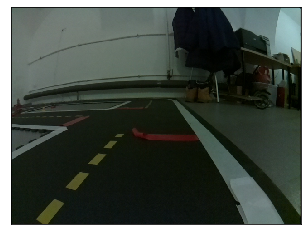

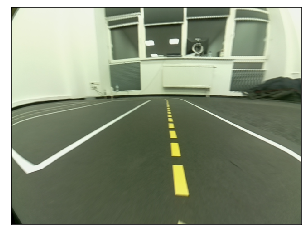

(480, 640, 3)


In [2]:
def imShow(img):
    plt.imshow(img, cmap="gray")
    plt.xticks([]), plt.yticks([])
    plt.show()
    
road = cv2.imread("images_from_itmo/image2.png")
jb   = cv2.imread("jb_2.png")
jb   = cv2.resize(jb, (640, 480))
jb   = cv2.cvtColor(jb, cv2.COLOR_BGR2RGB)
road = cv2.resize(road, (640, 480))
road = cv2.cvtColor(road, cv2.COLOR_BGR2RGB)
imShow(road)
imShow(jb)
print(road.shape)

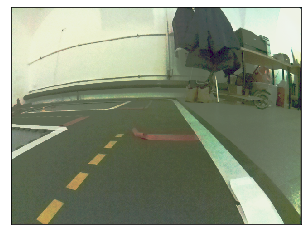

In [3]:
import skimage
matched = skimage.exposure.match_histograms(road, jb, multichannel=True)
#road = matched
imShow(matched)

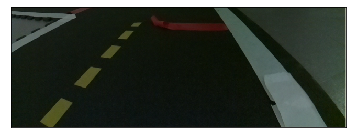

(230, 640, 3)


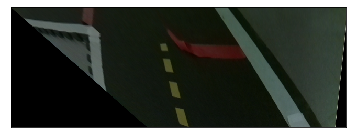

(230, 640, 3)


In [4]:
img = dp(road[250:,:,:])
#road = cv2.cvtColor(road, cv2.COLOR_BGR2RGB)
init_img = dp(img)
imShow(img)
print(img.shape)
#M = np.array( [[-1.27373e-05, -0.0002421778, -0.1970125], [0.001029818, -1.578045e-05, -0.337324], [-0.0001088811, -0.007584862, 1]])
M = np.array([[1.01123, 3.01646, -2.5], [0, 2.65629, 0], [0, 0.00513, 1]  ])
M_inv = np.linalg.inv(M)
#M_inv = 
size = (img.shape[1], img.shape[0])
out = cv2.warpPerspective(img, M, size)
imShow(out)
img = dp(out)
print(out.shape)

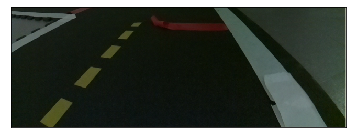

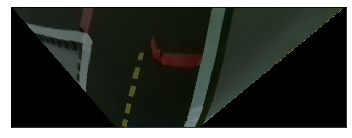

In [5]:
img = dp(road[250:,:,:])

IMAGE_H, IMAGE_W,_ = img.shape

src = np.float32([[0, IMAGE_H], [640, IMAGE_H], [0, 0], [IMAGE_W, 0]])
dst = np.float32([[200, IMAGE_H], [360, IMAGE_H], [0, 0], [IMAGE_W, 0]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped_img = cv2.warpPerspective(img, M, (IMAGE_W, IMAGE_H))

imShow(img)
imShow(warped_img)

In [6]:
#-----Reading the image-----------------------------------------------------

#-----Converting image to LAB Color model-----------------------------------
lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
#-----Splitting the LAB image to different channels-------------------------
l, a, b = cv2.split(lab)
#-----Applying CLAHE to L-channel-------------------------------------------
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
cl = clahe.apply(l)
ca = clahe.apply(a)
cb = clahe.apply(b)

#-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
limg = cv2.merge((l,a,cb))

#-----Converting image from LAB Color model to RGB model--------------------
img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

#_____END_____#

In [7]:
    
def getHist(img):
    first_channel = cv2.calcHist([img], [0], None, [256],[0,256])
    second_channel = cv2.calcHist([img], [1], None, [256],[0,256])
    third_channel = cv2.calcHist([img], [2], None, [256],[0,256])
    
    first_channel = np.reshape( first_channel, (256) ).astype(np.int64)
    second_channel = np.reshape( second_channel, (256) ).astype(np.int64)
    third_channel = np.reshape( third_channel, (256) ).astype(np.int64)
    
    return (first_channel, second_channel, third_channel)

def BHEMHB(hist, img):
    print(img.shape)
    h, w = img.shape
    
    repeats = np.repeat( np.arange(0, 256), hist )
    median_index = int( np.floor((h*w) / 2 + 1))
    median = repeats[median_index]
    
    print(median)
    #median = 170
    
    min_val = repeats[0]
    max_val = repeats[-1]
    
    norm_hist = hist / ( h * w )
    
    p_low = norm_hist[0:median]
    p_up = norm_hist[median:]
    
    p_low = np.log2(p_low + 1)
    p_up = np.log2(p_up + 1)
    
    cs_low = np.cumsum(p_low)
    cs_up = np.cumsum(p_up)
    
    for i in range(h):
        for j in range(w):
            if img[i, j] < median:
                img[i, j] = min_val + (median - 1 - min_val) * cs_low[ img[i, j] ]
            else:
                img[i, j] = median + (max_val - median) * cs_up[ img[i, j] - median ]
                
    return img

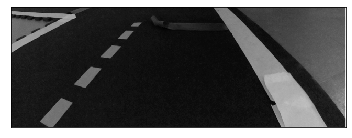

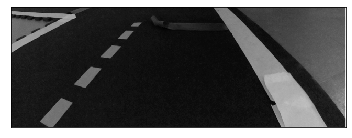

In [8]:
l,a,b =  cv2.split(limg)
imShow(l)
#res_l = BHEMHB(getHist(img)[0], l)
res_l=l
imShow(res_l)

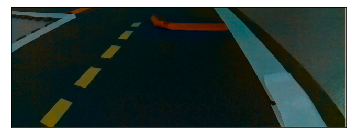

In [9]:
imShow(img)

In [10]:

# labels1 = segmentation.slic(img, compactness=30, n_segments=400)
# out1 = color.label2rgb(labels1, img, kind='avg')

# imShow(out1)

In [11]:
blur = cv2.GaussianBlur(img,(5,5),0)
img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

L, a, b = cv2.split(img_lab)
L = res_l

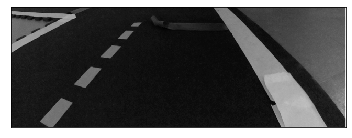

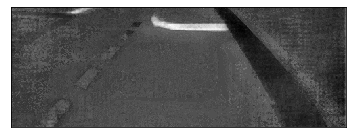

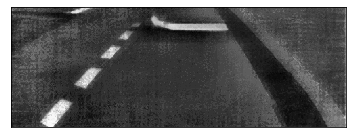

In [12]:
imShow(L)
imShow(a)
imShow(b)

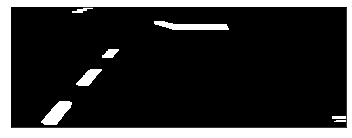

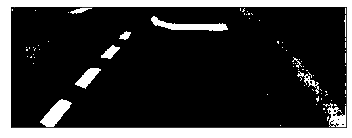

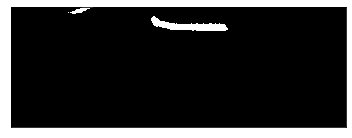

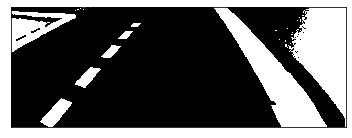

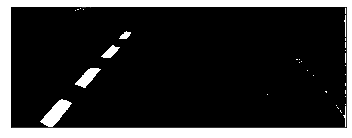

(230, 640)


In [13]:
_, thresh_b = cv2.threshold(b, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
otsu_thresh, thresh_L = cv2.threshold(L, 120, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
otsu_thresh, thresh_a = cv2.threshold(a, 150, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
kernel = np.ones((3,20),np.uint8)
#erosion = cv2.erode(thresh_b,kernel,iterations = 2)
closing = cv2.morphologyEx(thresh_b, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

imShow(closing)
imShow(thresh_b)
imShow(thresh_a)
imShow(thresh_L)
thresh_comb = cv2.bitwise_and( thresh_b, thresh_L )
#thresh_comb = thresh_L
imShow(thresh_comb)

print(thresh_L.shape)

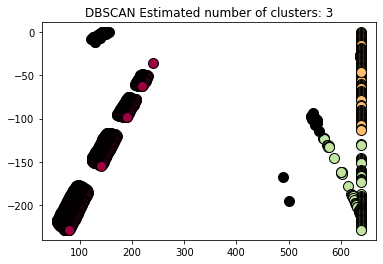

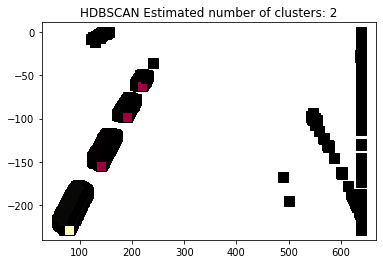

In [50]:
# Prepare thresholded points for DBSCAN clustering algorithm
from math import sqrt, ceil
from sklearn.cluster import DBSCAN
import scipy as sp
import hdbscan

maxpoints=35000
proxthresh=0.09

binimg = thresh_comb
X = np.transpose(np.where(binimg == 255))
Xslice = X
nsample = len(Xslice)
if nsample > maxpoints:
    # Make sure number of points does not exceed DBSCAN maximum capacity
    Xslice = X[range(0,nsample,int(ceil(float(nsample)/maxpoints)))]

# Translate DBSCAN proximity threshold to units of pixels and run DBSCAN
pixproxthr = proxthresh * sqrt(binimg.shape[0]**2 + binimg.shape[1]**2)
db = DBSCAN(eps=pixproxthr, min_samples=100).fit(Xslice)
labels = db.labels_.astype(int)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Find the largest cluster (i.e., with most points) and obtain convex hull   
unique_labels = set(labels)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], -xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 1], -xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

plt.title('DBSCAN Estimated number of clusters: %d' % n_clusters_)
plt.show()

hdb = hdbscan.HDBSCAN(min_cluster_size=100,min_samples=250, cluster_selection_epsilon=pixproxthr).fit(Xslice)
labels = hdb.labels_.astype(int)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Find the largest cluster (i.e., with most points) and obtain convex hull   
unique_labels = set(labels)
#core_samples_mask = np.zeros_like(hdb.labels_, dtype=bool)
#core_samples_mask[hdb.core_sample_indices_] = True
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], -xy[:, 0], 's', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 1], -xy[:, 0], 's', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)
    
plt.title('HDBSCAN Estimated number of clusters: %d' % n_clusters_)
plt.show()


maxclustpt = 0
for k in unique_labels:
    class_members = [index[0] for index in np.argwhere(labels == k)]
    if k == 2:
        points = Xslice[class_members]
        hull = sp.spatial.ConvexHull(points)
        maxclustpt = len(class_members)
        borderseg = [[points[simplex,0], points[simplex,1]] for simplex
                      in hull.simplices]

[[array([186, 185]), array([115, 115])], [array([186, 190]), array([115, 112])], [array([183, 185]), array([114, 115])], [array([183, 179]), array([114, 106])], [array([178, 179]), array([103, 106])], [array([177, 177]), array([98, 96])], [array([177, 178]), array([ 98, 103])], [array([178, 177]), array([92, 96])], [array([220, 190]), array([ 88, 112])], [array([226, 229]), array([83, 80])], [array([226, 220]), array([83, 88])], [array([229, 229]), array([80, 70])], [array([193, 178]), array([78, 92])], [array([193, 203]), array([78, 69])], [array([203, 218]), array([69, 56])], [array([224, 229]), array([62, 70])], [array([224, 220]), array([62, 56])], [array([220, 218]), array([56, 56])]]


(230, -1)

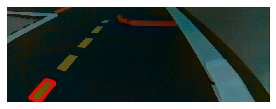

In [51]:
print(borderseg)
borderseg = sorted(borderseg, key=lambda pair: pair[1][0], reverse=True)
fgsz = (16,7)
rgbimg = img
figborder = plt.figure(figsize=fgsz, facecolor='w')
axborder = figborder.add_subplot(2,3,1)
axborder.set_axis_off()
axborder.imshow(rgbimg, interpolation='nearest')
for vseg, hseg in borderseg:
        axborder.plot(hseg, vseg, 'r-', lw=3)
axborder.set_xlim(0, binimg.shape[1]-1)
axborder.set_ylim(binimg.shape[0], -1)


In [ ]:
contours, hierarchy = cv2.findContours(thresh_L, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
imShow(img)

imShow(img)
print(img.shape)
#thresh_comb = cv2.resize(thresh_comb, (img.shape[1], img.shape[0]))
rez = cv2.warpPerspective(dp(thresh_comb), M, size)
rez_color = cv2.warpPerspective(dp(img), M, size)
imShow(rez)
imShow(rez_color)
#print(rez.shape)


#gray = cv2.cvtColor(rez,cv2.COLOR_BGR2GRAY)
_,thresh = cv2.threshold(rez,1,255,cv2.THRESH_BINARY)
contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]

for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        area = cv2.contourArea(box)

        if area > 0 and area < 8500:
            cv2.drawContours(img, [box], -1, (0,255,0), 3)

x,y,w,h = cv2.boundingRect(cnt)
crop = rez[y:y+h,x:x+w]

crop = cv2.resize(crop, (640, 330))
print(crop.shape)

imShow(img)
#imShow(road[150:,:,:])

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
for cnt in contours:
    #print(1)
    perimeter = cv2.arcLength(cnt,True)
    approx = cv2.approxPolyDP(cnt, 0.1 * perimeter, True)
    if len(approx) == 4:
        (x, y, w, h) = cv2.boundingRect(approx)
        #print(2)
        ar = w / float(h)
        area = cv2.contourArea(cnt)
        if (ar >= 0.35 or ar <= 0.65) and (area > 50 and area < 4000):
            #print(len(approx))
            cv2.drawContours(out,[approx],0,(0,0,255),-1)
            #cv2.putText(out, str(ar), (x,y), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
            
imShow(out)

In [ ]:
M_inv = np.array([[0.9889, -0.6455, 4.5], [0, 0.2148, 0], [0, -0.0011, 1]  ])

In [ ]:
size = (out.shape[1], out.shape[0])
rez = cv2.warpPerspective(out, M, size, flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_TRANSPARENT)
imShow(rez)

In [ ]:
imShow(rez)
imShow(crop)
imShow(init_img)

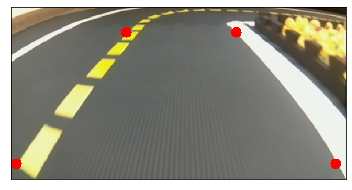

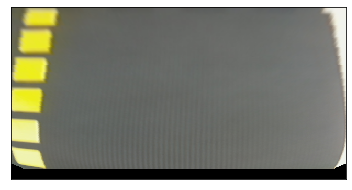

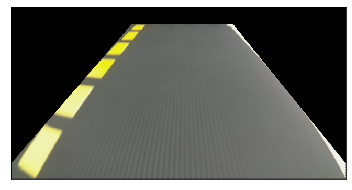

In [16]:
road = cv2.imread("curve_road.png")
road = cv2.resize(road, (640, 480))
road = road[150:,:,:]
proj = dp(road)
cv2.circle(proj, (10, 300), 10, (255, 0, 0), -1)
cv2.circle(proj, (620, 300), 10, (255, 0, 0), -1)
cv2.circle(proj, (220, 50), 10, (255, 0, 0), -1)
cv2.circle(proj, (430, 50), 10, (255, 0, 0), -1)
imShow(proj)
srcPoints = np.array( [[10, 300], [620, 300], [220, 50], [430, 50]] )
dstPoints = np.array( [[10, 300], [620, 300], [10, 50], [620, 50]] )

homogenius = cv2.getPerspectiveTransform(srcPoints.astype(np.float32), dstPoints.astype(np.float32))
inv_homogenius = cv2.getPerspectiveTransform( dstPoints.astype(np.float32), srcPoints.astype(np.float32) )

warped = cv2.warpPerspective(road, homogenius, (proj.shape[1], proj.shape[0]))
imShow(warped)

unwarped = cv2.warpPerspective(warped, inv_homogenius, (proj.shape[1], proj.shape[0]))
imShow(unwarped)

In [17]:
tform = tf.ProjectiveTransform(matrix=M)
tform_inv = tf.ProjectiveTransform(matrix=M_inv)

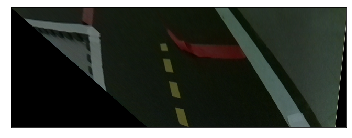

In [18]:
warped = tf.warp(init_img, tform_inv, order=3)
imShow(warped)

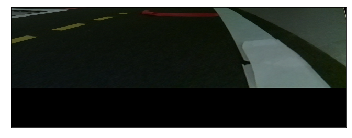

In [19]:
unwarped = tf.warp(init_img, tform_inv.inverse, order=3)
imShow(unwarped)

In [20]:
H = np.array([-1.27373e-05, -0.0002421778, -0.1970125, 0.001029818, -1.578045e-05, -0.337324, -0.0001088811, -0.007584862, 1])
H.resize( 4,4 )
print(H)
print("----------------------------------------------------")
K = np.array([305.5718893575089, 0, 303.0797142544728, 0, 308.8338858195428, 231.8845403702499, 0, 0, 1])
K.resize(3, 3)
print(K)
print("----------------------------------------------------")
D = np.array([-0.2944667743901807, 0.0701431287084318, 0.0005859930422629722, -0.0006697840226199427, 0])
D.resize(1, 5)
print(D)
print("----------------------------------------------------")
R = np.array([1, 0, 0, 0, 1, 0, 0, 0, 1])
R.resize(3, 3)
print(R)
print("----------------------------------------------------")
P = np.array([220.2460277141687, 0, 301.8668918355899, 0, 0, 238.6758484095299, 227.0880056118307, 0, 0, 0, 1, 0])
P.resize(3, 4)
print(P)

[[-1.273730e-05 -2.421778e-04 -1.970125e-01  1.029818e-03]
 [-1.578045e-05 -3.373240e-01 -1.088811e-04 -7.584862e-03]
 [ 1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]]
----------------------------------------------------
[[305.57188936   0.         303.07971425]
 [  0.         308.83388582 231.88454037]
 [  0.           0.           1.        ]]
----------------------------------------------------
[[-0.29446677  0.07014313  0.00058599 -0.00066978  0.        ]]
----------------------------------------------------
[[1 0 0]
 [0 1 0]
 [0 0 1]]
----------------------------------------------------
[[220.24602771   0.         301.86689184   0.        ]
 [  0.         238.67584841 227.08800561   0.        ]
 [  0.           0.           1.           0.        ]]


In [ ]:
cv_rect = np.zeros((proj.shape[1], proj.shape[0]))

mapx = np.ndarray(shape=(proj.shape[1], proj.shape[0], 1), dtype='float32')
mapy = np.ndarray(shape=(proj.shape[1], proj.shape[0], 1), dtype='float32')

mapx, mapy = cv2.initUndistortRectifyMap(K, D, R, P, (proj.shape[1], proj.shape[0]), cv2.CV_32FC1, mapx, mapy)

resulted = cv2.remap(road, mapx, mapy, cv2.INTER_CUBIC, cv_rect)
imShow(resulted)

In [ ]:
H = np.array([-4.89775e-05, -0.0002150858, -0.1818273, 0.00099274, 1.202336e-06, -0.3280241, -0.0004281805, -0.007185673, 1]).astype(np.float32)
H.resize(3, 3)
print(H)
H_inv = np.linalg.inv(H.T)

In [ ]:
warped = cv2.warpPerspective(road, H, (proj.shape[1], proj.shape[0]))
imShow(warped)

In [ ]:
img = dp(road[150:,:,:])

H = np.array([[-4.89775e-05, -0.0002150858, -0.1818273], [0.00099274, 1.202336e-06, -0.3280241], [-0.0004281805, -0.007185673, 1]])
H = H * img.shape[0] * img.shape[1]
H_inv = np.linalg.inv(H)
warped = cv2.warpPerspective(img, H, (img.shape[1], img.shape[0]))
imShow(warped)


In [ ]:
M = np.array([1.9353899780957532e-05, -0.00017594652267255518, -0.23530068966442091,
  0.0009113161348561763, 4.211150887794892e-06, -0.26092989999696975, 0.00014208256631522472,
  -0.00600411520134865, 0.9999999999999999]).reshape((3, 3))
M_inv = np.linalg.inv(M)

In [ ]:
test_img = cv2.imread("test.jpg")
test_img = cv2.resize(test_img, (640, 480))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
imShow(test_img)

warped = cv2.warpPerspective(test_img, M_inv, (test_img.shape[1], test_img.shape[0]))
print(warped.shape)
print(test_img.shape)

imShow(warped)

In [ ]:
test_img = cv2.imread("test.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
imShow(test_img)

tform = tf.ProjectiveTransform(matrix=M)
tform_inv = tf.ProjectiveTransform(matrix=M_inv)

warped = tf.warp(test_img, tform_inv, order=3)
imShow(warped)